In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Egg_Dataset/egg.zip'
extract_path = '/content/'

# Unzip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


Moved 94 damaged and 90 not damaged images to test set
Removed 373 old augmented images
Training - Damaged: 538 Not Damaged: 137
Need to generate 463 more images
Generated 463 augmented images
New counts - Damaged: 538 Not Damaged: 600


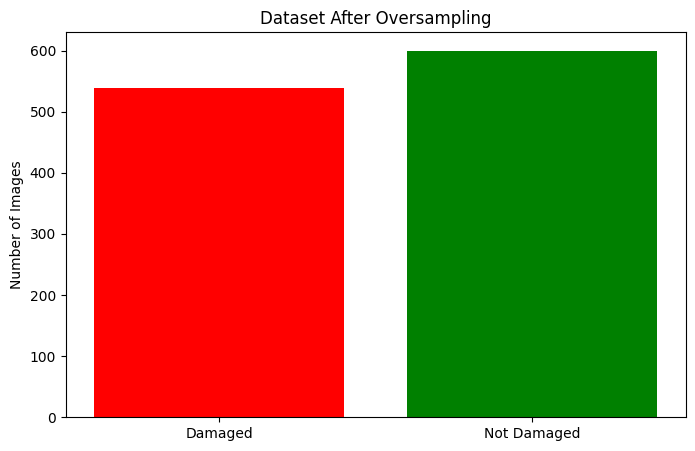

Class weights - Damaged: 1.06 Not Damaged: 0.95
Found 911 images belonging to 2 classes.
Found 227 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Training samples: 911
Validation samples: 227
Test samples: 184


In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
import shutil

dataset_path = '/content/Eggs Classification'
test_path = '/content/Eggs Test'
img_size = (150, 150)
batch_size = 16

# Create test directory structure
os.makedirs(os.path.join(test_path, 'Damaged'), exist_ok=True)
os.makedirs(os.path.join(test_path, 'Not Damaged'), exist_ok=True)

damaged_path = os.path.join(dataset_path, 'Damaged')
not_damaged_path = os.path.join(dataset_path, 'Not Damaged')
test_damaged_path = os.path.join(test_path, 'Damaged')
test_not_damaged_path = os.path.join(test_path, 'Not Damaged')

# Move 15% of data to test set
def move_to_test(source_path, test_path, test_ratio=0.15):
    images = [f for f in os.listdir(source_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    num_test = int(len(images) * test_ratio)
    np.random.seed(42)
    test_images = np.random.choice(images, num_test, replace=False)

    for img in test_images:
        shutil.move(os.path.join(source_path, img), os.path.join(test_path, img))

    return num_test

moved_damaged = move_to_test(damaged_path, test_damaged_path)
moved_not_damaged = move_to_test(not_damaged_path, test_not_damaged_path)
print(f"Moved {moved_damaged} damaged and {moved_not_damaged} not damaged images to test set")

# Clean old augmented images
augmented_files = [f for f in os.listdir(not_damaged_path) if f.startswith(('aug_', 'conservative_aug_'))]
for file in augmented_files:
    os.remove(os.path.join(not_damaged_path, file))
print("Removed", len(augmented_files), "old augmented images")

# Count images
num_damaged = len([f for f in os.listdir(damaged_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
num_not_damaged = len([f for f in os.listdir(not_damaged_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
print("Training - Damaged:", num_damaged, "Not Damaged:", num_not_damaged)

# Balance dataset
target_not_damaged = 600
additional_needed = target_not_damaged - num_not_damaged

if additional_needed > 0:
    not_damaged_images = [f for f in os.listdir(not_damaged_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    print("Need to generate", additional_needed, "more images")

    aug_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1],
        fill_mode='constant',
    )

    augmented_count = 0
    images_per_original = max(1, additional_needed // len(not_damaged_images)+1)

    for img_file in not_damaged_images:
        if augmented_count >= additional_needed:
            break

        try:
            img_path = os.path.join(not_damaged_path, img_file)
            img = load_img(img_path)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            aug_iter = aug_datagen.flow(
                img_array,
                batch_size=1,
                save_to_dir=not_damaged_path,
                save_prefix=f'aug_{augmented_count:04d}',
                save_format='jpg',
                seed=42
            )

            for i in range(images_per_original):
                if augmented_count >= additional_needed:
                    break
                next(aug_iter)
                augmented_count += 1

        except Exception as e:
            print("Error with", img_file, ":", e)
            continue

    print("Generated", augmented_count, "augmented images")

    num_not_damaged = len([f for f in os.listdir(not_damaged_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    print("New counts - Damaged:", num_damaged, "Not Damaged:", num_not_damaged)

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0, 1]),
    y=np.concatenate([np.zeros(num_damaged), np.ones(num_not_damaged)])
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights - Damaged:", round(class_weight_dict[0], 2), "Not Damaged:", round(class_weight_dict[1], 2))

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Training samples:", train_generator.samples)
print("Validation samples:", validation_generator.samples)
print("Test samples:", test_generator.samples)

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Clear previous models
tf.keras.backend.clear_session()

# Build model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("MobileNetV2 Model Built")
model.summary()

/tmp/ipython-input-3034996487.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


MobileNetV2 Model Built


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    min_lr=0.000001
)

checkpoint = ModelCheckpoint(
    '/content/best_mobilenet_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

callbacks = [early_stopping, reduce_lr, checkpoint]

print("Callbacks configured")

Callbacks configured


In [14]:
from tensorflow.keras.optimizers import Adam

# Check data
sample_images, sample_labels = next(train_generator)
positive_count = np.sum(sample_labels)
negative_count = len(sample_labels) - positive_count
print("Batch - Positive:", positive_count, "Negative:", negative_count)

# Fix class weights
class_weight_dict_fixed = {0: float(class_weight_dict[0]), 1: float(class_weight_dict[1])}
print("Class weights:", class_weight_dict_fixed)

# Calculate steps
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

def train_classifier_head(model, train_gen, val_gen, class_weights, epochs=15):
    print("Training classifier head")

    base_model.trainable = False
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    callbacks_phase1 = [
        EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=0.00001),
        ModelCheckpoint('/content/mobilenet_phase1.keras', monitor='val_accuracy', save_best_only=True)
    ]

    history = model.fit(
        train_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        class_weight=class_weights,
        callbacks=callbacks_phase1,
        verbose=1
    )

    best_acc = max(history.history['val_accuracy'])
    print("Phase 1 completed - Best accuracy:", round(best_acc, 4))
    return history

print("Starting Phase 1 training...")

try:
    history1 = train_classifier_head(
        model=model,
        train_gen=train_generator,
        val_gen=validation_generator,
        class_weights=class_weight_dict_fixed,
        epochs=15
    )

    phase1_best_accuracy = max(history1.history['val_accuracy'])
    print("PHASE 1 COMPLETED - Best accuracy:", round(phase1_best_accuracy, 4))

except Exception as e:
    print("Training failed:", e)

Batch - Positive: 6.0 Negative: 10.0
Class weights: {0: 1.0576208178438662, 1: 0.9483333333333334}
Steps per epoch: 56
Validation steps: 14
Starting Phase 1 training...
Training classifier head


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 703ms/step - accuracy: 0.5751 - loss: 0.8559 - precision: 0.5893 - recall: 0.5878 - val_accuracy: 0.8214 - val_loss: 0.4449 - val_precision: 0.8468 - val_recall: 0.8034 - learning_rate: 1.0000e-04
Epoch 2/15
 1/56 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.5385 - precision: 0.8571 - recall: 0.6667

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7500 - loss: 0.5385 - precision: 0.8571 - recall: 0.6667 - val_accuracy: 0.8214 - val_loss: 0.4406 - val_precision: 0.8468 - val_recall: 0.8034 - learning_rate: 1.0000e-04
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 404ms/step - accuracy: 0.8061 - loss: 0.4450 - precision: 0.8103 - recall: 0.8296 - val_accuracy: 0.8839 - val_loss: 0.3162 - val_precision: 0.8699 - val_recall: 0.9145 - learning_rate: 1.0000e-04
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6875 - loss: 0.4745 - precision: 0.6667 - recall: 0.5714 - val_accuracy: 0.8839 - val_loss: 0.3153 - val_precision: 0.8699 - val_recall: 0.9145 - learning_rate: 1.0000e-04
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 399ms/step - accuracy: 0.8722 - loss: 0.2959 - precision: 0.8707 - recall: 0.8634 - val_accuracy: 0.8929 - val_loss: 0.2616 - val_precision: 0.8908 - val_recall: 0.9060 - learning_rate: 1.0000e-04
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accura

PHASE 1 EVALUATION
Best accuracy: 0.9241


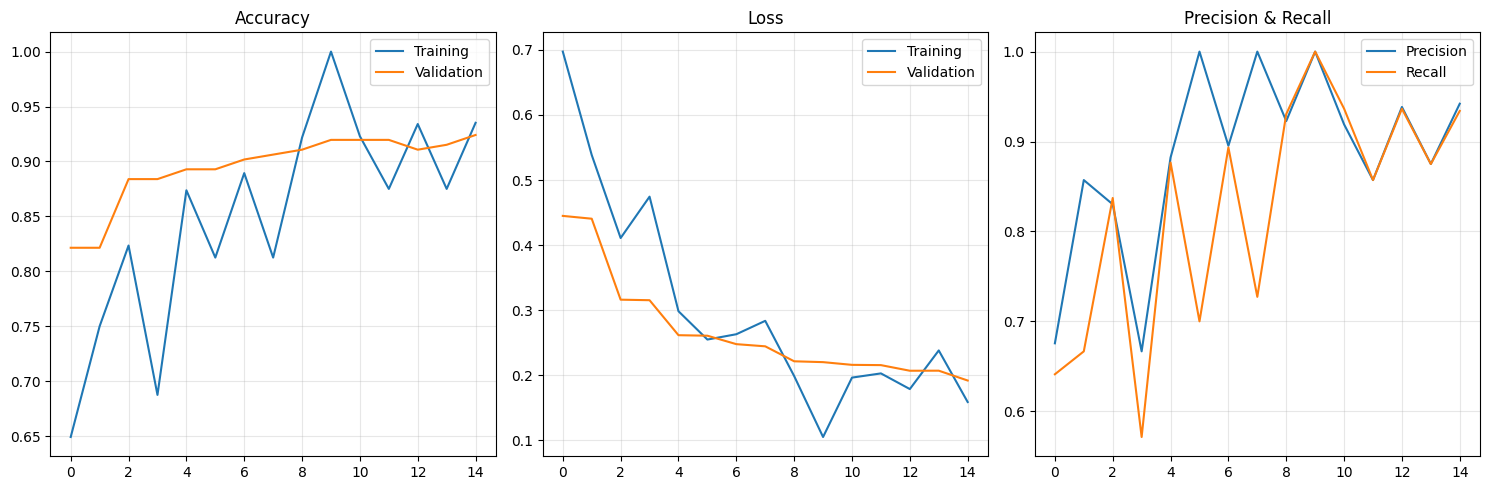

Training: 0.9352
Validation: 0.9241
Gap: 0.0111
Phase 2 - Unfreeze: 30 LR: 5e-06 Epochs: 15


In [15]:
import matplotlib.pyplot as plt
import numpy as np

print("PHASE 1 EVALUATION")

# Get best accuracy
phase1_best_accuracy = max(history1.history['val_accuracy'])
print("Best accuracy:", round(phase1_best_accuracy, 4))

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history1.history['precision'], label='Precision')
plt.plot(history1.history['recall'], label='Recall')
plt.title('Precision & Recall')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance check
final_train_acc = history1.history['accuracy'][-1]
final_val_acc = history1.history['val_accuracy'][-1]
accuracy_gap = final_train_acc - final_val_acc

print("Training:", round(final_train_acc, 4))
print("Validation:", round(final_val_acc, 4))
print("Gap:", round(accuracy_gap, 4))

# Phase 2 settings
if phase1_best_accuracy >= 0.92:
    recommended_unfreeze = 30
    recommended_lr = 0.000005
    recommended_epochs = 15
else:
    recommended_unfreeze = 50
    recommended_lr = 0.00001
    recommended_epochs = 20

print("Phase 2 - Unfreeze:", recommended_unfreeze, "LR:", recommended_lr, "Epochs:", recommended_epochs)

In [16]:
print("PHASE 2 - FINE-TUNING")

def fine_tune_model(model, train_gen, val_gen, class_weights, unfreeze_layers=30, epochs=15, learning_rate=0.000005):
    print("Unfreezing last", unfreeze_layers, "layers")

    # Unfreeze layers
    base_model.trainable = True
    for i, layer in enumerate(base_model.layers):
        layer.trainable = i >= len(base_model.layers) - unfreeze_layers

    # Recompile
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    # Callbacks
    callbacks_phase2 = [
        EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0000001),
        ModelCheckpoint('/content/mobilenet_final.keras', monitor='val_accuracy', save_best_only=True)
    ]

    # Train
    history = model.fit(
        train_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        class_weight=class_weights,
        callbacks=callbacks_phase2,
        verbose=1
    )

    return history

# Run Phase 2
history2 = fine_tune_model(
    model=model,
    train_gen=train_generator,
    val_gen=validation_generator,
    class_weights=class_weight_dict_fixed,
    unfreeze_layers=recommended_unfreeze,
    epochs=recommended_epochs,
    learning_rate=recommended_lr
)

# Results
phase1_best = max(history1.history['val_accuracy'])
phase2_best = max(history2.history['val_accuracy'])
improvement = phase2_best - phase1_best

print("Phase 1:", round(phase1_best, 4))
print("Phase 2:", round(phase2_best, 4))
print("Improvement:", round(improvement, 4))
print("Training completed!")

PHASE 2 - FINE-TUNING
Unfreezing last 30 layers
Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 624ms/step - accuracy: 0.8009 - loss: 0.3807 - precision: 0.9475 - recall: 0.6659 - val_accuracy: 0.9330 - val_loss: 0.1943 - val_precision: 0.8984 - val_recall: 0.9829 - learning_rate: 5.0000e-06
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6250 - loss: 0.7195 - precision: 1.0000 - recall: 0.5385 - val_accuracy: 0.9330 - val_loss: 0.1943 - val_precision: 0.8984 - val_recall: 0.9829 - learning_rate: 5.0000e-06
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.8726 - loss: 0.2777 - precision: 0.9348 - recall: 0.8173 - val_accuracy: 0.9241 - val_loss: 0.1988 - val_precision: 0.8846 - val_recall: 0.9829 - learning_rate: 5.0000e-06
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9375 - loss: 0.2678 - precision: 1.0000 - recall: 0.8889 - val_accuracy: 0.9241 - val_loss: 0.1989 - val_precision: 0.8846 - val_recall: 0.9829 - learning_rate: 5.0000e-06


MODEL EVALUATION ON TEST SET
Total test samples: 184
Damaged: 94 Not Damaged: 90

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Damaged     0.9451    0.9149    0.9297        94
 Not Damaged     0.9140    0.9444    0.9290        90

    accuracy                         0.9293       184
   macro avg     0.9295    0.9297    0.9293       184
weighted avg     0.9299    0.9293    0.9294       184


CONFUSION MATRIX
Actual \ Predicted   Damaged   Not Damaged
Damaged                86          8      
Not Damaged            5           85     

Test Accuracy: 0.9293


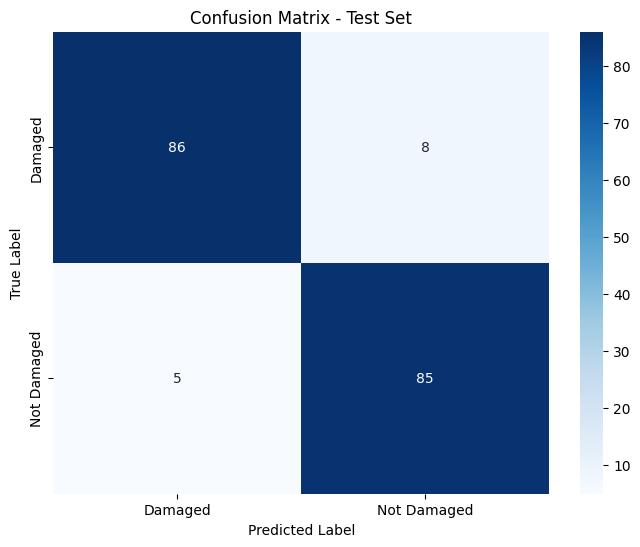

In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("MODEL EVALUATION ON TEST SET")

# Load best model
model.load_weights('/content/mobilenet_final.keras')

# Reset test generator
test_generator.reset()

all_predictions = []
all_true_labels = []

print("Collecting predictions from test set...")

# Get predictions for all test data
for i in range(len(test_generator)):
    batch_images, batch_labels = next(test_generator)
    batch_predictions = model.predict(batch_images, verbose=0)

    all_predictions.extend(batch_predictions.flatten())
    all_true_labels.extend(batch_labels)

# Convert to arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Convert probabilities to class predictions
predicted_classes = (all_predictions > 0.5).astype(int)

print("Total test samples:", len(all_true_labels))
print("Damaged:", np.sum(all_true_labels == 0), "Not Damaged:", np.sum(all_true_labels == 1))

# Classification Report
print("\nCLASSIFICATION REPORT")
print(classification_report(all_true_labels, predicted_classes,
                          target_names=['Damaged', 'Not Damaged'],
                          digits=4))

# Confusion Matrix
cm = confusion_matrix(all_true_labels, predicted_classes)
print("\nCONFUSION MATRIX")
print("Actual \\ Predicted   Damaged   Not Damaged")
print("Damaged            {:^10} {:^12}".format(cm[0,0], cm[0,1]))
print("Not Damaged        {:^10} {:^12}".format(cm[1,0], cm[1,1]))

# Overall accuracy
accuracy = np.mean(predicted_classes == all_true_labels)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Damaged', 'Not Damaged'],
            yticklabels=['Damaged', 'Not Damaged'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [18]:
import os
from google.colab import drive
from tensorflow.keras.models import load_model

print("SAVING MODEL TO GOOGLE DRIVE")

drive.mount('/content/drive')

# Load the BEST model (Phase 2)
model = load_model('/content/mobilenet_final.keras')

# Create folder
drive_path = '/content/drive/MyDrive/DL_Egg_Project/'
os.makedirs(drive_path, exist_ok=True)

# Save model
model_filename = 'egg_classifier_final_testset.keras'
full_path = drive_path + model_filename

model.save(full_path)

file_size = os.path.getsize(full_path) / (1024*1024)
print("Model saved!")
print("Location:", full_path)
print("Size:", round(file_size, 1), "MB")

SAVING MODEL TO GOOGLE DRIVE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved!
Location: /content/drive/MyDrive/DL_Egg_Project/egg_classifier_final_testset.keras
Size: 22.7 MB


Upload an egg image to test...


Saving egg3.jpg to egg3.jpg
Testing: egg3.jpg


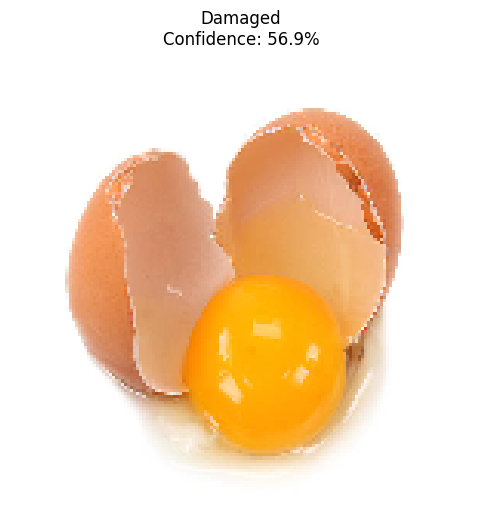

Prediction: Damaged
Confidence: 56.9%


In [26]:
from google.colab import files
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model

# Load model (add this if starting fresh session)
model = load_model('/content/mobilenet_final.keras')

print("Upload an egg image to test...")
uploaded = files.upload()

if uploaded:
    # Get uploaded file
    image_name = list(uploaded.keys())[0]
    print("Testing:", image_name)

    # Load and preprocess
    img = tf.keras.preprocessing.image.load_img(image_name, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    prediction = model.predict(img_array, verbose=0)[0][0]

    # Interpret result
    if prediction > 0.5:
        result = "Not Damaged"
        confidence = prediction
    else:
        result = "Damaged"
        confidence = 1 - prediction

    # Show result
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'{result}\nConfidence: {confidence:.1%}')
    plt.axis('off')
    plt.show()

    print("Prediction:", result)
    print("Confidence:", f"{confidence:.1%}")

    # Clean up
    os.remove(image_name)
else:
    print("No file uploaded")